In [78]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
from plotly import express as px
import plotly.io as pio
import seaborn as sns
import xml.etree.ElementTree as ET
from tensorflow.keras import losses,models
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils 
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,Callback
from tensorflow.keras.applications import VGG16,ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten,Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [58]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Images/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
(train_dataset, validation_dataset, test_dataset), metadata = tfds.load(
    'stanford_dogs',
    split=['train[:90%]', 'train[70%:90%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [94]:
batch_size=32
image_size=(224,224)

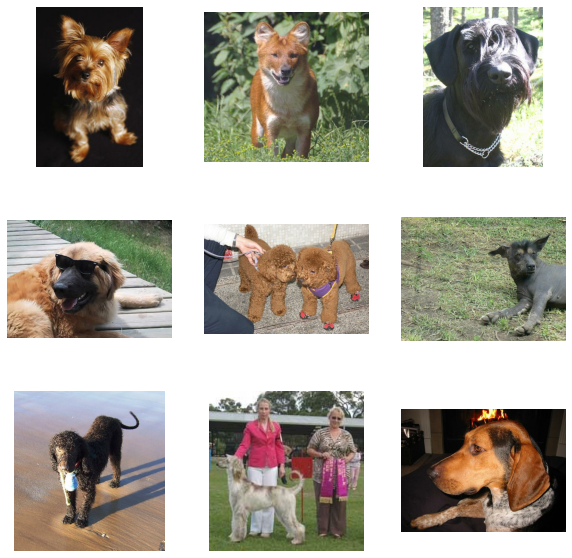

In [95]:
#show 9 pictures from training dataset.
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_ds.take(9)): #take first 9 pictures
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.axis('off')


VGG16 Model

In [62]:
#We use vgg16 model as our base model
vgg=VGG16(include_top=False,weights='imagenet', input_shape=(224,224,3))
vgg.trainable = False

In [63]:
vgg.summary() #show the summary of the model

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [65]:
vgg.output
for layer in vgg.layers:
  layer.trainable=False

In [52]:
#split dataset into training dataset and validation dataset.
#we add some data augment layers into base model in order to increase the accuracy
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    
    rescale=1./255, #normalize image
    zoom_range=0.2,  #zoom out image
    horizontal_flip=True, #flip left to right
    validation_split=0.1 # take 10% data as validation dataset.
)
validation_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [61]:
# build train generator and validation generator to train and test our model 
train_generator=train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    subset='training'
)
validation_generator=validation_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    subset='validation'
)

Found 18625 images belonging to 120 classes.
Found 2014 images belonging to 120 classes.


In [70]:

x=Flatten()(vgg.output)
prep=Dense(120,activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prep)

In [71]:
#run our model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator,
          epochs=20,
          validation_data=validation_generator,
         )

Epoch 1/20
 12/583 [..............................] - ETA: 1:11:51 - loss: 0.1016 - accuracy: 0.0286

ResNet50V2 model

In [ ]:
#evaluate model
model.evaluate(test_dataset)

In [ ]:
#make a plot for accuracy
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()

In [81]:
Res_model=ResNet50V2(include_top=False,
                     input_shape=(224,224,3),
                      pooling='avg',
                      classes=120,
                      weights='imagenet')

94683136/94668760 [==============================] - 2s 0us/step


In [82]:
Res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [86]:
Res_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [90]:
for layer in Res_model.layers:
  layer.trainable=False

In [ ]:
history1=Res_model.fit(train_generator,
          epochs=20,
          validation_data=validation_generator,
         )

In [ ]:
Res_model.evaluate(test_dataset)

In [ ]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='validation')
plt.legend()

In [ ]:
Res_model.add()